1. Data Preparation

In [18]:
import pandas as pd
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the dataset
df = pd.read_csv('data.csv').drop_duplicates(subset=['id'])
df = df[~df['tags'].str.contains('shorts', case=False, na=False)]


# Ensure correct data types and handle missing values
df['liked'] = df['liked'].astype(int)
df['tags'] = df['tags'].fillna('')
df['viewCount'] = df['viewCount'].fillna(0)
df['duration_sec'] = df['duration_sec'].fillna(df['duration_sec'].median())
df['channelTitle'] = df['channelTitle'].fillna('Unknown')


2. Comparative Analysis

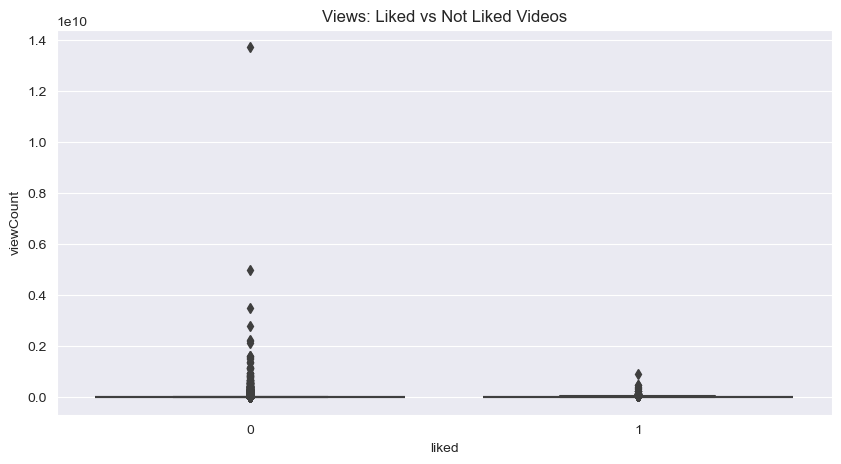

In [19]:
# Statistical Test for Views
liked_views = df[df['liked'] == 1]['viewCount']
not_liked_views = df[df['liked'] == 0]['viewCount']
t_stat, p_value = ttest_ind(liked_views, not_liked_views, equal_var=False)

# Visualization
plt.figure(figsize=(10, 5))
sns.boxplot(x='liked', y='viewCount', data=df)
plt.title('Views: Liked vs Not Liked Videos')
plt.show()


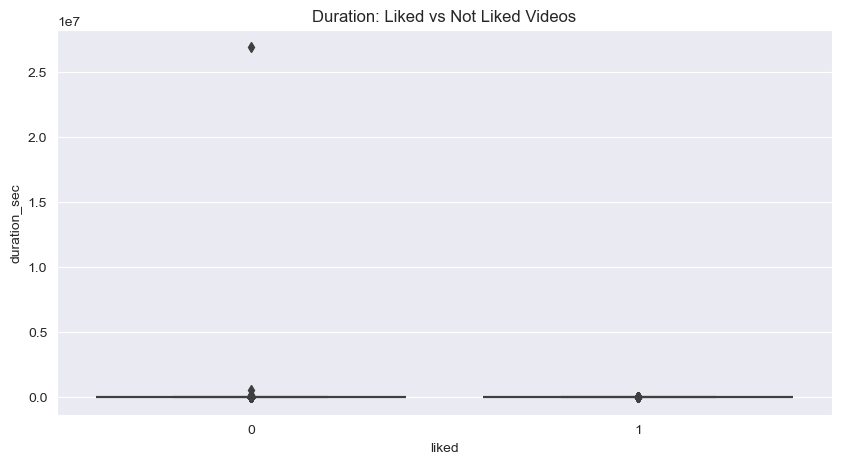

In [20]:
# Statistical Test for Video Length
liked_duration = df[df['liked'] == 1]['duration_sec']
not_liked_duration = df[df['liked'] == 0]['duration_sec']
t_stat_duration, p_value_duration = ttest_ind(liked_duration, not_liked_duration, equal_var=False)

# Visualization
plt.figure(figsize=(10, 5))
sns.boxplot(x='liked', y='duration_sec', data=df)
plt.title('Duration: Liked vs Not Liked Videos')
plt.show()


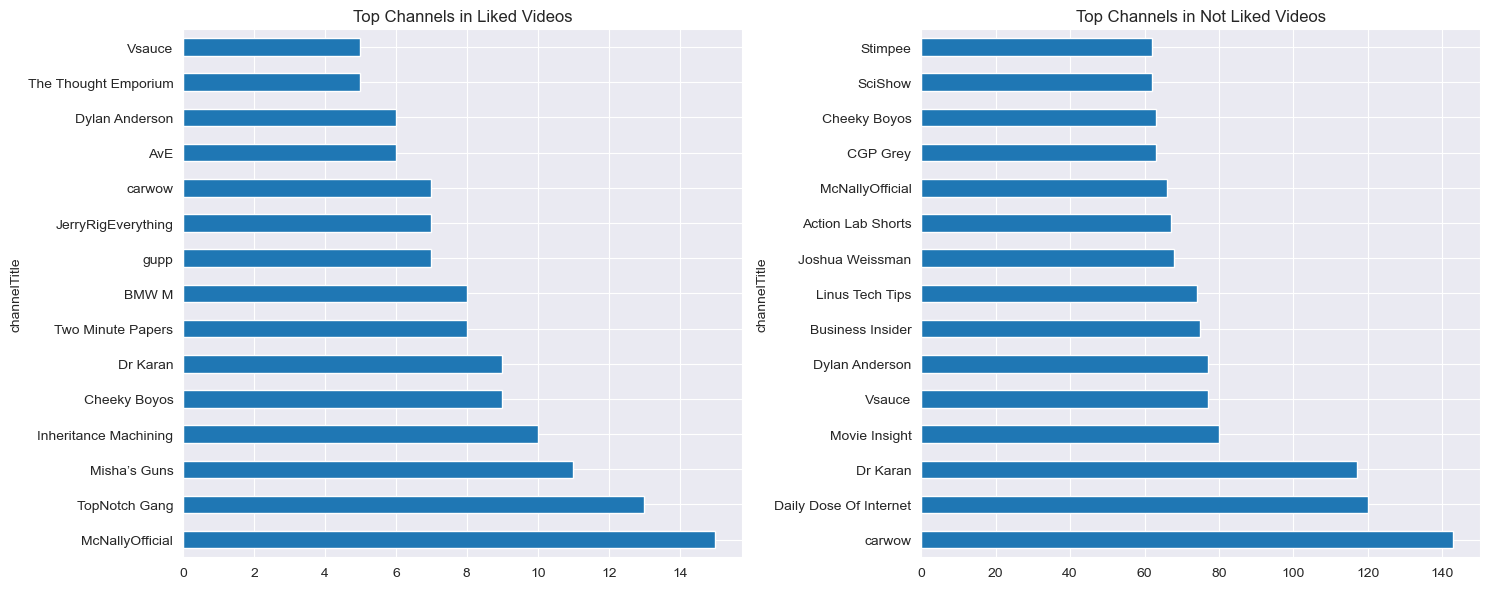

In [25]:
# Frequency Analysis for Channels
liked_channels = df[df['liked'] == 1]['channelTitle'].value_counts().head(15)
not_liked_channels = df[df['liked'] == 0]['channelTitle'].value_counts().head(15)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
liked_channels.plot(kind='barh', ax=axes[0], title='Top Channels in Liked Videos')
not_liked_channels.plot(kind='barh', ax=axes[1], title='Top Channels in Not Liked Videos')
plt.tight_layout()
plt.show()


you may not like it but this is what peak performance looks like.

3. Tag Analysis

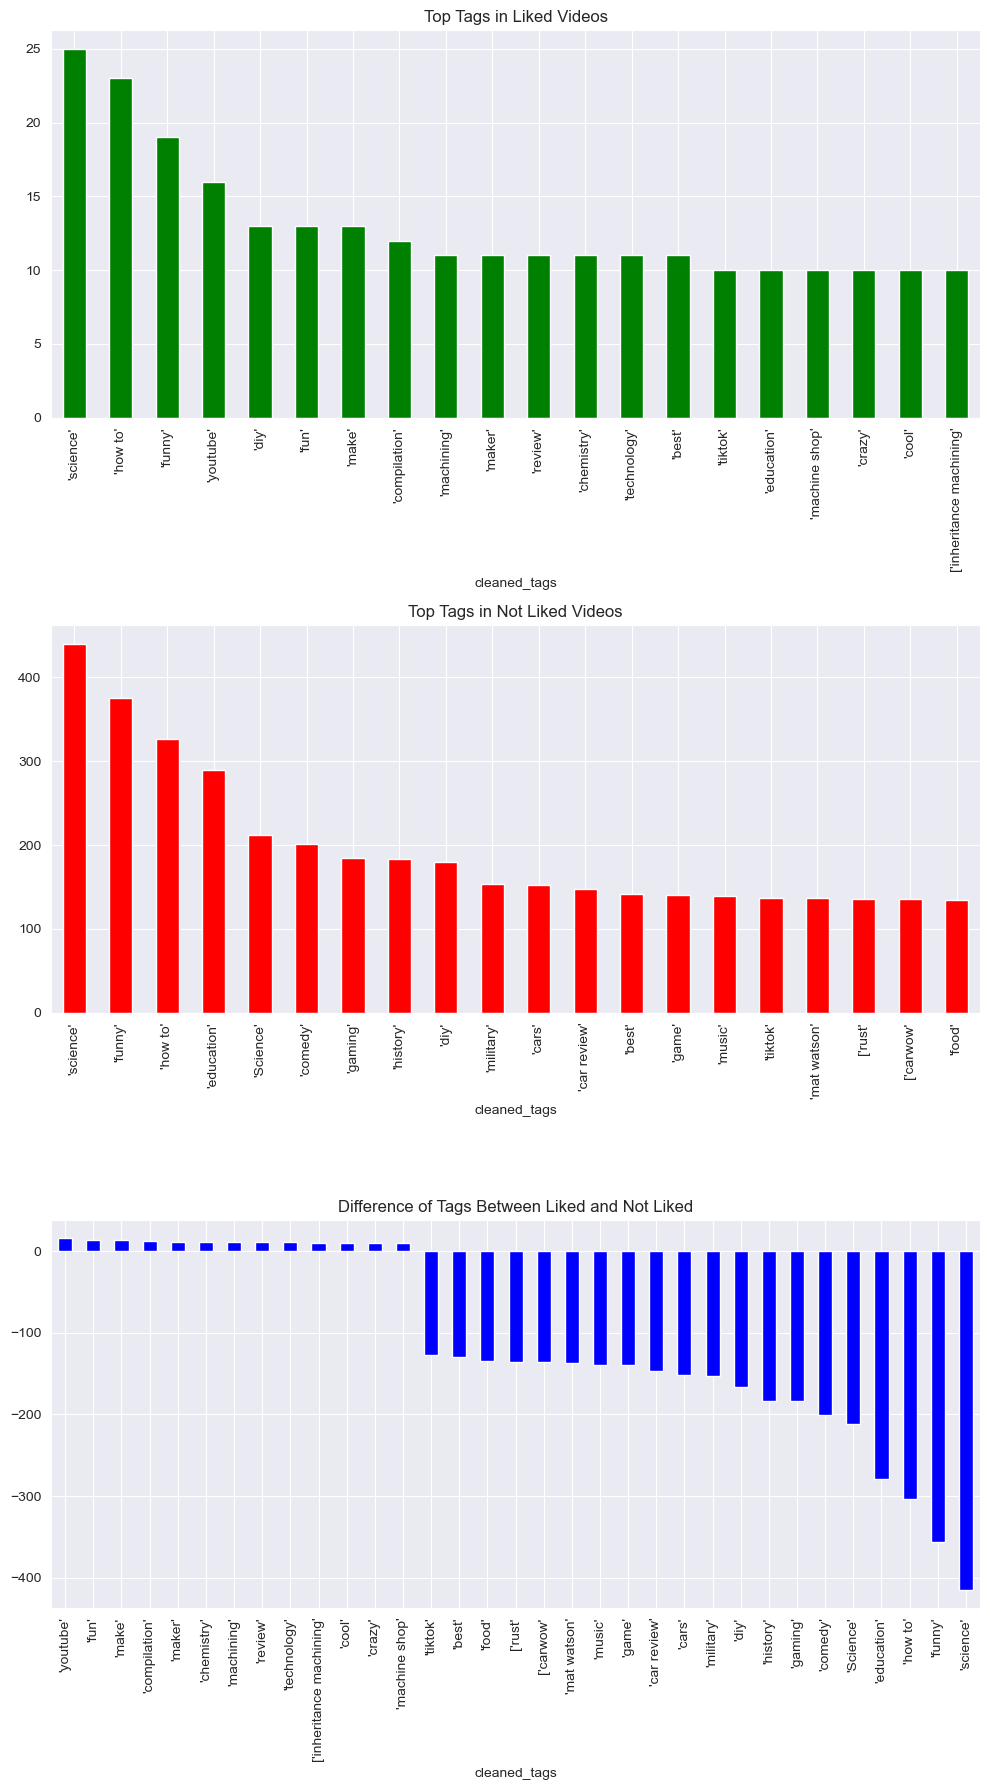

In [45]:
import matplotlib.pyplot as plt

# Function to clean and split tags
def clean_and_split_tags(tag_str):
    return [tag.strip() for tag in tag_str.split(',') if tag]

# Split and clean tags
df['cleaned_tags'] = df['tags'].apply(clean_and_split_tags)

# Liked and Not Liked Tags
liked_tags = df[df['liked'] == 1]['cleaned_tags'].explode().value_counts()
not_liked_tags = df[df['liked'] == 0]['cleaned_tags'].explode().value_counts()

# Top Tags in Liked and Not Liked Videos
top_liked_tags = liked_tags.head(20)
top_not_liked_tags = not_liked_tags.head(20)

# Calculate the difference in tag frequencies
tag_difference = top_liked_tags.subtract(top_not_liked_tags, fill_value=0)
tag_difference[''] =

# Visualization
fig, axes = plt.subplots(3, 1, figsize=(10, 18))

top_liked_tags.plot(kind='bar', ax=axes[0], color='green', title='Top Tags in Liked Videos')
top_not_liked_tags.plot(kind='bar', ax=axes[1], color='red', title='Top Tags in Not Liked Videos')
tag_difference.sort_values(ascending=False).plot(kind='bar', ax=axes[2], color='blue', title='Difference of Tags Between Liked and Not Liked')



plt.tight_layout()
plt.show()


true taste

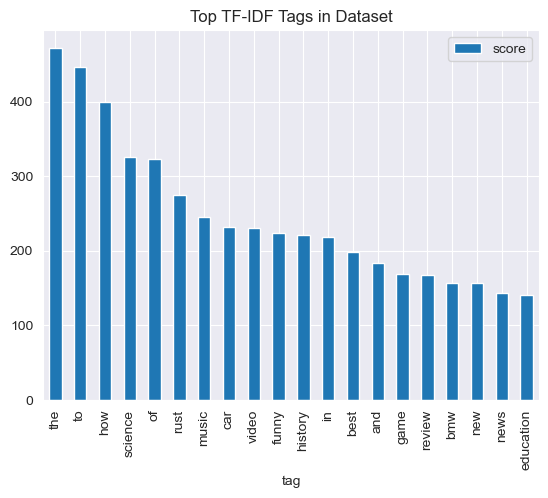

In [23]:
# TF-IDF Analysis
tfidf = TfidfVectorizer(max_features=500)
tfidf_matrix = tfidf.fit_transform(df['tags'])

# Summing up the TF-IDF scores for each tag
tag_scores = np.array(tfidf_matrix.sum(axis=0)).flatten()
tag_scores_df = pd.DataFrame({'tag': tfidf.get_feature_names_out(), 'score': tag_scores})

# Top scoring tags
top_tfidf_tags = tag_scores_df.sort_values(by='score', ascending=False).head(20)

# Visualization: Bar Chart
top_tfidf_tags.plot(x='tag', y='score', kind='bar', title='Top TF-IDF Tags in Dataset')
plt.show()


4. Multivariate Analysis

In [27]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

# Assuming df is your DataFrame and it contains a 'tags' column
# where each entry is a list of tags

# Flatten the list of all tags
all_tags = [tag for tags in df['tags'].dropna() for tag in tags.split(', ')]

# Count the frequency of each tag
tag_freq = pd.Series(all_tags).value_counts()

# Identify the top 'n' tags that cover at least 70% of videos
cumulative_coverage = tag_freq.cumsum() / len(df)
top_tags = tag_freq[cumulative_coverage <= 0.8].index.tolist()

# Initialize a DataFrame for tag features
tag_features = pd.DataFrame(index=df.index)

# Create binary columns for each top tag
for tag in top_tags:
    tag_features[f'tag_{tag}'] = df['tags'].fillna('').apply(lambda x: int(tag in x))

# Combine tag features with other features
X = pd.concat([df[['viewCount', 'likeCount', 'duration_sec', 'commentCount', 'subscribed']], tag_features], axis=1)
y = df['liked']

# Check for missing values and handle them
X.fillna(X.mean(), inplace=True)
y.fillna(0, inplace=True)  # Assuming NaN in 'liked' means not liked

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Resample with SMOTE to handle class imbalance
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Hyperparameter Tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='f1')
grid_search.fit(X_train_res, y_train_res)

# Best model
best_rf = grid_search.best_estimator_

# Make predictions and evaluate
y_pred = best_rf.predict(X_test)
print(classification_report(y_test, y_pred))

# Feature Importance
importances = best_rf.feature_importances_
feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': importances})
print(feature_importances.sort_values(by='importance', ascending=False))


              precision    recall  f1-score   support

           0       0.97      0.82      0.89      4784
           1       0.07      0.37      0.12       173

    accuracy                           0.80      4957
   macro avg       0.52      0.59      0.50      4957
weighted avg       0.94      0.80      0.86      4957

              feature  importance
4          subscribed    0.304533
2        duration_sec    0.154442
0           viewCount    0.132497
3        commentCount    0.126364
1           likeCount    0.119716
..                ...         ...
45   tag_'technology'    0.000429
54      tag_'youtube'    0.000385
50  tag_'compilation'    0.000309
59        tag_'scene'    0.000267
5                tag_    0.000000

[65 rows x 2 columns]


In [33]:
display(feature_importances)

,feature,importance
0,viewCount,0.132497
1,likeCount,0.119716
2,duration_sec,0.154442
3,commentCount,0.126364
4,subscribed,0.304533
...,...,...
60,tag_'car review 2023',0.000744
61,tag_'trump',0.000562
62,tag_'gameplay',0.000899
63,tag_'new car 2023',0.000576


the recall on liked videos is too low due to imbalance in dataset.

Hypothesis: The user is more likely to like a machining video than not